<a href="https://colab.research.google.com/github/shazoop/generalization-experiments/blob/main/MNIST_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(.3,.3)]
)

#One time for downloading the MNIST dataset. Don't need to download this again a second time.
trainset = torchvision.datasets.MNIST(root='./data', train = True , download = True, transform = transform)
testset = torchvision.datasets.MNIST(root='./data', train = False , download = True, transform = transform)



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
#Set the batch size

batch_size = 300

In [4]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)



In [5]:
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 9)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [7]:
def train_dbl(print_interval, model, device, train_loader, optimizer, epoch, num, num_alt):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        ix1 = (target == num)
        ix2 = (target == num_alt)
        ix = torch.logical_or(ix1,ix2)
        # ix = (target != num)
        data, target = data[ix], target[ix]
        target[target == num] = 0
        target[target == num_alt] = 1
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % print_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test_dbl(model, device, test_loader, num,num_alt):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # ix = (target != num)
            ix1 = (target == num)
            ix2 = (target == num_alt)
            ix = torch.logical_or(ix1,ix2)
            data, target = data[ix], target[ix]
            target[target == num] = 0
            target[target == num_alt] = 1
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    ix1 = test_loader.dataset.targets == num
    ix2 = test_loader.dataset.targets == num_alt
    ix = torch.logical_or(ix2, ix1)
    data_size = torch.sum(ix)
    test_loss /= data_size

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, data_size,
        100. * correct /data_size))


 



In [8]:
def train(print_interval, model, device, train_loader, optimizer, epoch, num, num_alt):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        ix = (target != num_alt)
        data, target = data[ix], target[ix]
        target[target == num] = -1
        target[target > num] -= 1
        target[target > (num_alt - (num_alt > num))] -= 1
        target += 1
        assert torch.max(target).item() == 8
        assert torch.min(target).item() == 0
        assert target.size(0) == data.size(0)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % print_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, num, num_alt):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            ix = (target != num_alt)
            data, target = data[ix], target[ix]
            target[target == num] = -1
            target[target > num] -= 1
            target[target > (num_alt - (num_alt > num))] -= 1
            target += 1
            assert torch.max(target).item() == 8
            assert torch.min(target).item() == 0
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    data_size = torch.sum(test_loader.dataset.targets != num_alt)
    test_loss /= data_size

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, data_size,
        100. * correct /data_size))


 


In [9]:
import torch.optim as optim

In [46]:
device = torch.device("cuda")
Model = net().to(device)
optimizer = optim.Adam(Model.parameters(), lr=0.001) #e-1


In [21]:
epoch = 3
print_interval = 10

In [47]:
num = 8
num_alt = 5

In [48]:
for eph in range(1, epoch+1):
  train(print_interval, Model, device, train_loader, optimizer, eph, num,num_alt)
  test(Model,device, test_loader, num, num_alt)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.196214
Train Epoch: 1 [2790/60000 (5%)]	Loss: 0.480815
Train Epoch: 1 [5380/60000 (10%)]	Loss: 0.213993
Train Epoch: 1 [7950/60000 (15%)]	Loss: 0.250552
Train Epoch: 1 [10600/60000 (20%)]	Loss: 0.182607
Train Epoch: 1 [13850/60000 (25%)]	Loss: 0.196207
Train Epoch: 1 [16800/60000 (30%)]	Loss: 0.160527
Train Epoch: 1 [18830/60000 (35%)]	Loss: 0.126895
Train Epoch: 1 [22000/60000 (40%)]	Loss: 0.107343
Train Epoch: 1 [25560/60000 (45%)]	Loss: 0.101963
Train Epoch: 1 [26100/60000 (50%)]	Loss: 0.087991
Train Epoch: 1 [30360/60000 (55%)]	Loss: 0.061461
Train Epoch: 1 [33120/60000 (60%)]	Loss: 0.053413
Train Epoch: 1 [35880/60000 (65%)]	Loss: 0.086097
Train Epoch: 1 [37800/60000 (70%)]	Loss: 0.102917
Train Epoch: 1 [40050/60000 (75%)]	Loss: 0.061378
Train Epoch: 1 [44640/60000 (80%)]	Loss: 0.042635
Train Epoch: 1 [46070/60000 (85%)]	Loss: 0.107503
Train Epoch: 1 [49860/60000 (90%)]	Loss: 0.089307
Train Epoch: 1 [51110/60000 (95%)]	Loss: 0.044715

Test set

In [49]:
# for eph in range(1, epoch+1):
#   train_dbl(print_interval, Model, device, train_loader, optimizer, eph, num2,num_alt)
#   test_dbl(Model,device, test_loader, num2, num_alt)

In [50]:
import copy

In [51]:
Model_clone = copy.deepcopy(Model)

In [52]:
class transnet(nn.Module):
    def __init__(self):
        super(transnet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.fc1 = nn.Linear(4608, 28*28)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        # x = self.fc2(x)
        # x = F.relu(x)
        # x = self.fc3(x)
        # x = F.relu(x)
        x = torch.reshape(x,(-1,1,28,28))
        return x


class stacknet(nn.Module):
    def __init__(self, translator, classifier):
        super(stacknet, self).__init__()
        self.translator = translator
        self.classifier = classifier
    def forward(self, x):
        x = self.translator(x)
        x = self.classifier(x)
        return x

In [53]:
trans = transnet().to(device)

In [54]:
stack = stacknet(trans,Model_clone).to(device)

In [55]:
test(stack, device, test_loader, num, num_alt)


Test set: Average loss: 2.2692, Accuracy: 983/9108 (11%)



In [56]:
test(Model_clone, device, test_loader, num, num_alt) #works well on trained class


Test set: Average loss: 0.0365, Accuracy: 9004/9108 (99%)



In [57]:
test(Model_clone, device, test_loader, num_alt, num) #and fails on unseen class


Test set: Average loss: 0.3083, Accuracy: 8344/9026 (92%)



In [58]:
for par in stack.classifier.parameters():
  par.requires_grad = False

In [59]:
optimizer = optim.Adam(stack.parameters(), lr=1e-3) #e-1

In [60]:
for eph in range(1, epoch+1):
  train(print_interval, stack, device, train_loader, optimizer, eph, num_alt, num)
  test(stack,device, test_loader, num_alt, num)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298140
Train Epoch: 1 [2630/60000 (5%)]	Loss: 0.317677
Train Epoch: 1 [5340/60000 (10%)]	Loss: 0.232765
Train Epoch: 1 [8310/60000 (15%)]	Loss: 0.165344
Train Epoch: 1 [10920/60000 (20%)]	Loss: 0.114740
Train Epoch: 1 [13500/60000 (25%)]	Loss: 0.142213
Train Epoch: 1 [15660/60000 (30%)]	Loss: 0.111316
Train Epoch: 1 [19390/60000 (35%)]	Loss: 0.098823
Train Epoch: 1 [21600/60000 (40%)]	Loss: 0.057890
Train Epoch: 1 [24030/60000 (45%)]	Loss: 0.138716
Train Epoch: 1 [26900/60000 (50%)]	Loss: 0.046653
Train Epoch: 1 [29480/60000 (55%)]	Loss: 0.057619
Train Epoch: 1 [31320/60000 (60%)]	Loss: 0.090371
Train Epoch: 1 [35230/60000 (65%)]	Loss: 0.031027
Train Epoch: 1 [37660/60000 (70%)]	Loss: 0.047455
Train Epoch: 1 [40200/60000 (75%)]	Loss: 0.073152
Train Epoch: 1 [43520/60000 (80%)]	Loss: 0.043576
Train Epoch: 1 [46070/60000 (85%)]	Loss: 0.046235
Train Epoch: 1 [48240/60000 (90%)]	Loss: 0.056594
Train Epoch: 1 [51490/60000 (95%)]	Loss: 0.073041

Test set

In [61]:
test(Model_clone, device, test_loader, num, num_alt)


Test set: Average loss: 0.0365, Accuracy: 9004/9108 (99%)



In [62]:
test(Model_clone, device, test_loader, num_alt, num) #classifier still works perfectly on original but fails on novel class. no change.


Test set: Average loss: 0.3083, Accuracy: 8344/9026 (92%)



In [63]:
import matplotlib.pyplot as plt

In [69]:
dat, tar = next(iter(test_loader))
ix = (tar != num)
dat, tar = dat[ix], tar[ix]
tar[tar == num_alt] = -1
tar[tar > num_alt] -= 1
tar[tar > (num - (num > num_alt))] -= 1
tar += 1



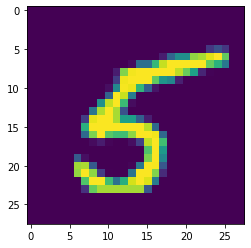

In [70]:
ex_ix = torch.argmin(tar).item()
plt.imshow(dat[ex_ix].view(28,28))

In [71]:
print(num,num_alt)

8 5


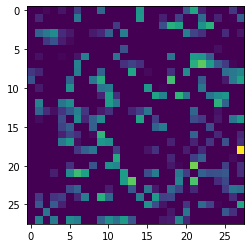

In [72]:
out_dat = stack.translator(dat.to(device))
out_dat_cpu = out_dat.cpu().detach()
plt.imshow(out_dat_cpu[ex_ix].view(28,28))

In [73]:
out = stack.classifier(out_dat)
pred = out.argmax(dim=1, keepdim=True)

In [74]:
pred.squeeze(1).cpu() == tar

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, 

The translator net won't learn to morph "num_alt" into "num", even when trained to correctly classify all but "num_alt" originally. INTUITION: given train classifier, partition pixel space into classification regions. Then,translator is just learning to map "num_alt" into the classification region of "num", and this region is not specific enough to just digits of "num". Include lots of other stuff. NEXT: perhaps this is a good way to check if classifier really "learns" the class. If one can learn a map from some random pixel space to classification region of a certain class, if the region is truly attuned to the class then the learned map should generate instances of that class (that appear so to the human observer)